In [4]:
# Run These lines to download dataset
!wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
!unzip cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_

# Import Libraries

In [5]:
import numpy as np
np.random.seed(1000) # To reproduce the random behaviour

import cv2
import glob, os
from PIL import Image

from tensorflow import keras

# Loading and preprocessing dataset

In [6]:
# data_directory = '/content/cell_images/'
SIZE = 64
dataset = []
label = []

# Adding all the parasitized images to a dataset list
parasitized_images = os.listdir('/content/cell_images/Parasitized/')
for i, image_name in enumerate(parasitized_images):
    if image_name.split('.')[1] == 'png':
        img = cv2.imread('/content/cell_images/Parasitized/' + image_name)
        img = Image.fromarray(img, 'RGB')
        img = img.resize((SIZE, SIZE))
        dataset.append(np.array(img))
        label.append(0)

# Adding all the uninfected images to a dataset list
uninfected_images = os.listdir('/content/cell_images/Uninfected')
for i, image_name in enumerate(uninfected_images):
    if image_name.split('.')[1] == 'png':
        img = cv2.imread('/content/cell_images/Uninfected' + f'/{image_name}')
        img = Image.fromarray(img, 'RGB')
        img = img.resize((SIZE, SIZE))
        dataset.append(np.array(img))
        label.append(1)

In [7]:
len(dataset)

27558

In [8]:
dataset[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

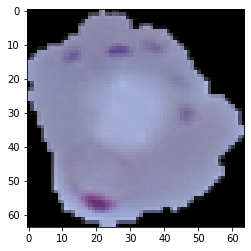

In [9]:
import matplotlib.pyplot as plt
plt.imshow(dataset[10000]);

# Building the Model

In [10]:
INPUT_SHAPE = (SIZE, SIZE, 3) # Input shape of the image

# Creating a convolutional block
def conv_block(model, filter_size):
    model.add(keras.layers.Conv2D(filters=filter_size, kernel_size=3,
                                  activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    return model

# Defining our model with sequential api
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=INPUT_SHAPE)) # Input layers

# Adding two convolutional block with 32 and 64 filters
model = conv_block(model, 32)
model = conv_block(model, 32)

#Flatten 
model.add(keras.layers.Flatten())

# Adding few Dense Layers
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

# Output layer
model.add(keras.layers.Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        1

# Preparing our dataset

In [11]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(dataset,
                                                    to_categorical(np.array(label)), 
                                                    test_size=0.2, random_state=0)

# Train the model

In [26]:
history = model.fit(np.array(X_train), y_train,
                    batch_size=62,
                    epochs=25,
                    validation_split=0.1,
                    callbacks = [keras.callbacks.EarlyStopping(patience=5)],
                    shuffle=False)

Epoch 1/25
321/321 [==============================] - 3s 10ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.2984 - val_accuracy: 0.9478
Epoch 2/25
321/321 [==============================] - 3s 10ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.2958 - val_accuracy: 0.9492
Epoch 3/25
321/321 [==============================] - 3s 9ms/step - loss: 0.0065 - accuracy: 0.9976 - val_loss: 0.3040 - val_accuracy: 0.9488
Epoch 4/25
321/321 [==============================] - 3s 9ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.3108 - val_accuracy: 0.9474
Epoch 5/25
321/321 [==============================] - 3s 9ms/step - loss: 0.0059 - accuracy: 0.9978 - val_loss: 0.2874 - val_accuracy: 0.9478
Epoch 6/25
321/321 [==============================] - 3s 9ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.3750 - val_accuracy: 0.9497
Epoch 7/25
321/321 [==============================] - 3s 10ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.3109 - val_accuracy: 0.9506
Epo

In [27]:
loss, acc = model.evaluate(np.array(X_test), y_test)
print('Accuracy :', round(acc * 100, 2), '%')

173/173 [==============================] - 1s 3ms/step - loss: 0.3211 - accuracy: 0.9606
Accuracy : 96.06 %


# Plot the model performance

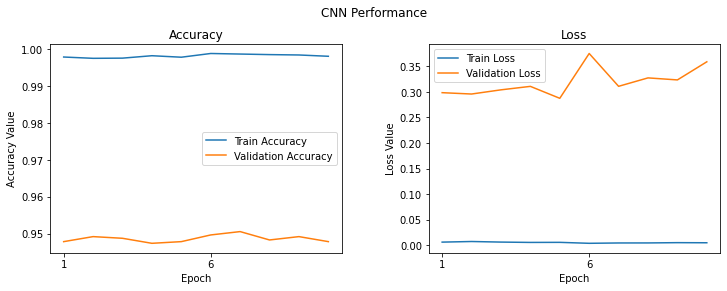

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Saving the model

In [32]:
model.save('malaria_cnn.h5')